# Topic Models

In [ ]:
from requests import get
import re

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import string
import time

from IPython.display import display, HTML


Also install `pyLDAvis` and import:

In [ ]:
%pip install pyLDAvis
import pyLDAvis.lda_model

We'll start by reading in some example data. This .csv contains articles scraped from CNN and Fox News from around 2020. 

In [ ]:
articles = pd.read_csv('https://github.com/Neilblund/APAN/raw/main/news_sample.csv')
articles['headline'] = articles.headline.str.strip()
articles.head()

Example of using some HTML markup to format hyperlinks for later: 

In [ ]:
articles['hyperlink']=articles.apply(axis=1, func = lambda x: f'<a href={x.url}>{x.headline}</a>')


## Text Analysis - Topic Modeling

Suppose we have a corpus of text data that we want to understand more about. We might want to get a sense for what was covered in the news in 2020. We could read all of them ... but that would take a really long time, and it would not be feasible to do that in any reasonable amount of time. Also, it'd be hard for us to process that amount of data manually. 

Instead, we can use a technique called **topic modeling** using **Latent Dirichlet Allocation** (LDA). This will allow us to automatically generate topics that describe the documents within a corpus, as well as determine which documents fit into which topics. 

To do this, though, we first need to convert texts to a "bag-of-words" representation and then into a format called a document-term-matrix.

In the last class, we converted texts to a bag-of-words by doing the following:


1. **Tokenization** splits texts into smaller units. In the current case, this will be individual words. But it could also be sentences, paragraphs or "n-gram" (groups of 1, 2, 3... words)
2. **Stopword Removal** removing common terms like "a", "and", "the" that are grammatically useful but uninformative for many text models
3. **Normalization** combining terms that are more-or-less equivalent by doing things like converting words to lower-case or removing word endings through stemming or lemmatization


(In some cases we may change the ordering of these steps, or we might do some cleaning and normalization and then decide, based on a closer look at our results, that we need to go back and do some additional cleaning. Our end goal, however, is generally to a representation of a text that is simple enough without sacrificing too much nuance or complexity

To make a document-term-matrix we're going to conver the bag of words to format with one row per document, one column for each word in the entire corpus, and a count of word "j" in document "i" in each cell. So:








<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">See</th>
    <th class="tg-0pky">Spot</th>
    <th class="tg-0pky">Run</th>
    <th class="tg-0pky">Fast</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-0pky">See Spot run.</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">0</td>
  </tr>
  <tr>
    <td class="tg-0pky">Spot runs fast</td>
    <td class="tg-0pky">0</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">1</td>
  </tr>
  <tr>
    <td class="tg-0pky">Run Spot run.</td>
    <td class="tg-0pky">0</td>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">2</td>
    <td class="tg-0pky">0</td>
  </tr>
</tbody>
</table>

(For efficiency's sake, document term matrices like this will typically be represented as "sparse matrices", which only index the non-zero elements of each cell, but at least conceptually you should still think of a document term matrix as being structured like the example above)



The `scikit-learn` package has a `CountVectorizer` function that will let us do all of this processing in a single step, so we'll use that to create a document term matrix. We'll start by lowercasing all of our text, then we'll create the Count Vectorizer and apply it to the text. 

In [614]:
text = articles.text.str.lower().reset_index().text.dropna()

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(token) for token in tokens]

eng_stopwords = [tokenize(s)[0] for s in stop]
vectorizer = CountVectorizer(analyzer= "word", # unit of features are single words rather then phrases of words 
                             tokenizer = tokenize,
                             ngram_range=(0,1), # Tokens are individual words for now
                             strip_accents='unicode',
                             stop_words= eng_stopwords,
                             max_df = 0.1, # maximum number of documents in which word j occurs. 
                             min_df = .0025 # minimum number of documents in which word j occurs. 
                            )



bag_of_words = vectorizer.fit_transform(text) #transform our corpus into a bag of words 
features = vectorizer.get_feature_names_out()



Our resulting object is a matrix with one row per document and one column per term. We'll feed this into subsequent text analysis models.

In [ ]:
bag_of_words.shape

### Latent Dirichlet Allocation

Next, we fit the Latent Dirichlet Allocation (LDA) model. LDA is a statistical model that generates groups based on similarities. This is an example of an **unsupervised machine learning model**. That is, we don't have any sort of outcome variable -- we just need to have some very rough idea regarding the number of topics in our corpus, and the LDA model will identify them for us. 


#### The Dirichlet Distribution

A dirichlet distribution is a probability distribution that can be used to describe the probability distribution for multivariate outcomes. For instance, if we were manufacturing a bunch of unbalanced dice, I could use a random dirichlet distribution to model the probability of each face:

In [ ]:
# 10 random unbalanced dice: 
rng = np.random.default_rng()
s = pd.DataFrame(rng.dirichlet((1,1,1,1,1,1), 10), columns = range(1, 7, 1))


<Axes: >

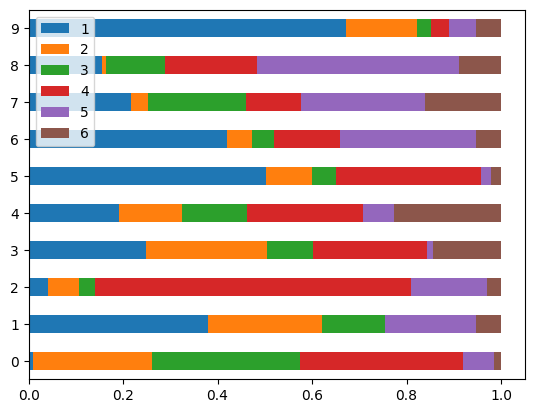

In [616]:
s.plot.barh(stacked=True)

In LDA, we assume that documents are created by sampling from two dirichlet distributions:


- The **Topic-word distribution** (sometimes called phi or beta)  models the probability of any word occuring in a single topic. A topic related to Covid-19 might have a high probability of terms like "Fauci", "mask", or vaccine". A topic related to the election might have a high probabiltiy of "vote", "caucus" or "turnout"
- The **Document-Topic distributions** (theta) models the probability of drawing one of K topics within a given document. So a document might be drawn 75% from the Covid-19 topic, 20% from the election topic, and 5% from some other random topic.



LDA assumes a generative model where each article is written randomly sampling topics from a document's topic distribution, and then randomly sampling each word from the chosen topic distribution. So I might write a document where I drew 75% of my words from a "Covid-topic" and 20% from a "election topic" and another 5% from some other random topic. 

Again: keep in mind that the actual topics here are *latent*: we'll never observe them. Instead, we assume they exist and then try to infer their parameters from the distribution of words in each document in the corpus. If our model works, then we should be able to identify topics from our LDA model that have high probabilities of a bunch of semantically related terms.


## Fitting the model

Let's try fitting an LDA model. We need to choose the number of topics ourselves. We'll assume there are 20 topics here. We'll also want to set a `random_state` value. Multiple LDA models with the same number of topics and the same data should find similar topics, but even then the ordering of those topics is arbitrary, so setting the `random_state` variable will ensure that we can replicate our results.



We first create a LatentDirichletAllocation object, then fit it using our corpus bag of words.

In [617]:
# Create LDA model object
k =15
lda = LatentDirichletAllocation(n_components = k, # number of topics. Try different numbers here to see what works best. Usually somewhere between 20 - 100
                                random_state = 941, # random number seed. You can use any number here, but its important to include so you can replicate analysis
                                doc_topic_prior = 1/k) 

# Fit using data (bag_of_words)
doctopic = lda.fit_transform(bag_of_words)

## Interpreting the results
A lot of the complexity of using LDA lies in intepreting the topics themselves. The simplest way to do this is by looking at the most probable words for each topic. 

In [618]:
# Displaying the top keywords in each topic

n_terms = 10
ls_keywords = []
ls_freqs = []
topic_id = []

for i,topic in enumerate(lda.components_):
    # Sorting and finding top keywords
    word_idx = np.argsort(topic)[::-1][:n_terms]
    freqs = list(np.sort(topic)[::-1][:n_terms])
    keywords = [features[i] for i in word_idx]
    
    # Saving keywords and frequencies for later
    ls_keywords = ls_keywords + keywords
    ls_freqs = ls_freqs + freqs
    topic_id = topic_id + [i+1] * n_terms
    

    # Printing top keywords for each topic
    print(i, ', '.join(keywords))

top_words_df = pd.DataFrame({'keywords':ls_keywords, 'frequency':ls_freqs, 'topic_id':topic_id})

0 walker, cheney, midterm, warnock, endors, democraci, runoff, stefanik, vanc, gun
1 mcconnel, elector, meadow, wall, select, project, fraud, subpoena, penc, overturn
2 appeal, amend, lawsuit, thoma, trial, robert, argument, barrett, opinion, circuit
3 afghanistan, taliban, afghan, cortez, troop, ocasio, evacu, withdraw, veteran, airport
4 hunter, classifi, fbi, email, search, counsel, garland, materi, doj, subpoena
5 vaccin, mask, virus, wear, diseas, spread, hospit, fauci, mandat, dr
6 penc, obama, clinton, percent, survey, bush, vaccin, favor, object, shot
7 mccarthi, pelosi, green, gender, parent, student, educ, protest, transgend, cruz
8 harri, carolina, scott, impeach, north, schumer, haley, mcconnel, graham, kamala
9 ukrain, china, russia, russian, intellig, chines, putin, ukrainian, iran, sanction
10 prosecutor, fbi, indict, sentenc, trial, cuomo, arrest, prison, juri, fals
11 mail, pennsylvania, virginia, michigan, arizona, wisconsin, cast, absente, youngkin, abram
12 tax, deb

<b style="color:red;"> Question 1: Wrap the code above in a function that takes `n_terms` and `lda` as arguments and returns a data frame with the top n terms for each topic in descending order of frequency. Try running the same function with a few different values for `n_terms`</b>

In [ ]:
# define a function here

We can also plot terms by frequency within each topic (although this may get unwieldy for models with a larger number of components)

In [ ]:
sns.catplot(top_words_df, x = 'frequency', y = 'keywords', col = 'topic_id', kind = 'bar', sharey = False, col_wrap=5)


In many cases, an interactive visualization can make it easier to identify topics. The LDAvis package provides an easy way to create an interactive HTML file. 

In [ ]:
#%pip install pyLDAvis
import pyLDAvis.lda_model


In [ ]:
panel = pyLDAvis.lda_model.prepare(lda, bag_of_words, vectorizer, mds='tsne', sort_topics=False, n_jobs = -1)
word_info = panel.topic_info

#To save panel in html
pyLDAvis.save_html(panel, 'panel.html')

In the left panel if the display below, you can see each topic scaled by its overall frequency in the corpus. The relative positions of each topic indicates how distinct they are, so that topics that are further apart should share fewer terms. The plot on the right will display top terms for each topic. Instead of using the probability of each term, the displayed in this visualization are ranked according to a metric that accounts for how specific each term is to each topic. In some cases, this can be a better way of identifying the concept each topic represents.

In [ ]:
HTML('panel.html')

<b style="color:red;"> Question 2: Using the information we've gathered so far, see if you can assign a short label to each topic in the LDA model. Replace the generic labels in `label_map` below with some descriptive topic IDs and then recreate the catplot object from the previous section</b>

In [ ]:
label_map = {
    0: 'topic 1',
    1: 'topic 2',
    2: 'topic 3',
    3: 'topic 4',
    4: 'topic 5',
    5: 'topic 6',
    6: 'topic 7',
    7: 'topic 8',
    8: 'topic 9',
    9: 'topic 10',
    10: 'topic 11',
    11: 'topic 12',
    12: 'topic 13',
    13: 'topic 14',
    14: 'topic 15',
}
# map the labels
top_words_df['topic_label'] = top_words_df['topic_id'].map(label_map)

# recreate the catplot object:
sns.catplot(top_words_df, x = 'frequency', y = 'keywords', col = 'topic_label', kind = 'bar', sharey = False, col_wrap=5)

## Identifying Document Topics

We can link the topic memberships in `doctopic` back to the original documents so that we can see which documents are getting categorized into which topics. This does mean we need to match the column name to the appropriate topic title, so you can also adjust the column titles with an appropriate one based on what you determined that topic to be.

In [ ]:
topic_memberships = pd.DataFrame(doctopic)
topic_memberships.head()

Each row in this result represents one of the documents from our original data, and each column represents a topic. We can make things a little easier to interpret by appending some information about each article as additional columns onto this data frame:

In [ ]:
topic_memberships['text'] = text
topic_memberships['source'] = articles.source
topic_memberships['headline'] =articles.headline
topic_memberships['url'] = articles.url
topic_memberships['hyperlink'] = articles.hyperlink

topic_memberships.head()

<b style="color:red;"> Question 3: Identify the top 5 articles most strongly associated with topic 6</b>

In [ ]:
# 



# Making a styled table

Since we included a hyperlink and an article title in our original data frame, we can make a styled table that includes a formatted link for the topic articles in each topic.

In [609]:
n_terms = 10
n_docs = 3
top_documents = []
top_index = topic_memberships.columns.values.tolist()
for i in range(k):
    top_n_documents =  topic_memberships.sort_values(i, ascending=False).head()
    terms={ 'topic' : i,
           'mean proportion' : np.mean(topic_memberships[i]),
        'docs' : '<br>'.join([i for i in top_n_documents['hyperlink'].to_list()[:n_docs]]),
        'terms' : ', '.join([features[j] for j in np.argsort(lda.components_[i])[::-1][:n_terms]]) 
    }
    top_documents.append(terms)



In [613]:
pd.DataFrame(top_documents).sort_values(['mean proportion'], ascending=False).style

,topic,mean proportion,docs,terms
12,12,0.104197,"Stimulus checks, unemployment and more: Here’s the aid that’s coming from Washington – and what might be coming soonMore than $15 billion in child tax credit payments distributed on FridayCovid relief programs are starting to expire for millions of Americans","tax, debt, packag, climat, loan, payment, energi, price, relief, inflat"
10,10,0.092846,Fact check: Trump falsely claims Roger Stone was ‘never’ involved in his campaignCuomo accuser Charlotte Bennett says gov should resign: 'I was terrified'Roger Stone denies he protected Trump to secure commutation of sentence,"prosecutor, fbi, indict, sentenc, trial, cuomo, arrest, prison, juri, fals"
9,9,0.086936,"China has expressed some openness to providing military and financial aid to Russia, US cable suggestsBiden announces more Russia sanctions over Ukraine war, 7K more US troops to GermanyBiden vows US will ‘forcefully protect our people’ as Iranian-backed groups launch more attacks on US troops in Syria","ukrain, china, russia, russian, intellig, chines, putin, ukrainian, iran, sanction"
5,5,0.080321,What if the government got it wrong on masks again?States are hitting pause on reopening. Here’s whyDC Mayor Bowser sparks backlash by posting indoor maskless photo,"vaccin, mask, virus, wear, diseas, spread, hospit, fauci, mandat, dr"
14,14,0.077506,Kentucky legislature overrides governor’s veto of sweeping abortion bill7 key state actions on abortion this weekLatest increase in illegal migrant crossings undercuts Biden admin claims of progress on border crisis,"abort, immigr, migrant, gun, drug, roe, illeg, mexico, medic, v"
7,7,0.072178,"Maryland school district unveils LGBTQ book list that teaches words 'intersex,' 'drag queen' to pre-K studentsLia Thomas controversy: NCAA silent amid mounting criticism over transgender athlete policyHouse passes anti-trans sports bill","mccarthi, pelosi, green, gender, parent, student, educ, protest, transgend, cruz"
0,0,0.069482,Herschel Walker spotlights image as a ‘uniter’ in his first general election ad in Georgia Senate raceWarnock accuses Loeffler of 'scandalizing my name'Rep. Liz Cheney compares herself to Abraham Lincoln following resounding defeat in Wyoming primary,"walker, cheney, midterm, warnock, endors, democraci, runoff, stefanik, vanc, gun"
2,2,0.067431,Georgia Supreme Court undecided on fate of appeals judge accused of ethical misconductSupreme Court resurrects pre-pandemic tradition: announcing opinions from benchSupreme Court to decide if First Amendment stops government officials from blocking social media critics,"appeal, amend, lawsuit, thoma, trial, robert, argument, barrett, opinion, circuit"
13,13,0.060928,"Biden’s surprise win in Texas caps historic Super Tuesday while Sanders turns to CaliforniaBiden’s surprise win in Texas caps historic Super Tuesday while Sanders turns to CaliforniaBiden surges to victory across Super Tuesday map, as Sanders claims delegate prize in California","desanti, sander, iowa, hampshir, endors, bloomberg, super, santo, ron, deleg"
11,11,0.057695,"Virginia's election is highlighted by 3 congressional races in newly drawn districtsIn Idaho, Republicans aim to maintain dominance. Here are the races to watch on Tuesday.Battleground state lawmakers seek law changes to avoid 'man-made disaster' of mail-in ballot delays","mail, pennsylvania, virginia, michigan, arizona, wisconsin, cast, absente, youngkin, abram"


<b style="color:red;"> Question 4: Try re-running the model with a larger number of topics. Compare your results. </b>